# Movie Recommender System

I'm using the well-known MovieLens dataset (in this case the small version).

In [1]:
import os, requests
import numpy as np

#mlSize = "ml-1m"
#mlSize = "ml-100k"
mlSize = "ml-latest-small"
zipUrl = 'http://files.grouplens.org/datasets/movielens/'+mlSize+'.zip'
zipFile = 'data/'+mlSize+'.zip'
dataFile = zipFile
url = zipUrl
dataDir = 'data'
if not os.path.exists(dataDir):
    os.makedirs(dataDir)
if not os.path.isfile(zipFile):
    r = requests.get(zipUrl)
    with open(zipFile, 'wb') as f:
        f.write(r.content)

# Need to unzip the file to read its contents
import zipfile
with zipfile.ZipFile(zipFile,"r") as zip_ref:
    zip_ref.extractall(dataDir)

In [2]:
# Read the ratings data into a dataframe
import pandas as pd
fn = 'ratings.csv'
colNames = ['UserID','MovieID','Rating','Timestamp']
ratingsDf = pd.read_csv('data/'+mlSize+'/'+fn, names=colNames, skiprows=1, sep=',', engine='python')
ratingsDf.head()

,UserID,MovieID,Rating,Timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
# Timestamps are difficult for humans to read, so convert them into a more readable format
import time
ts = time.gmtime()
print("Timestamp now is {} which is {}".format(str(ts),time.strftime("%Y-%m-%d %H:%M:%S", ts)))

Timestamp now is time.struct_time(tm_year=2023, tm_mon=5, tm_mday=10, tm_hour=16, tm_min=51, tm_sec=41, tm_wday=2, tm_yday=130, tm_isdst=0) which is 2023-05-10 16:51:41


In [4]:
ratingsDf['DateTime'] = pd.to_datetime(ratingsDf['Timestamp'],unit='s')
ratingsDf.drop(columns=['Timestamp'], inplace=True)
ratingsDf.head()

,UserID,MovieID,Rating,DateTime
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


In [6]:
moviesDf = pd.read_csv('data/'+mlSize+'/'+'movies.csv', sep=',', engine='python')

In [7]:
moviesDf.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


**Observations**

 * GroupLens no longer have user data because of privacy concerns and ethical considerations.
 * This means that GroupLens is using alternative approaches such as content-based filtering, collaborative filtering, and hybrid methods to generate recommendations without needing to collect user data.
 * This could result in providing slightly less personalised recommendations while protecting the user privacy.

The following code can be used to filter the number of Movies. Choosing a large threshold (like 200) ensures that only "blockbuster" movies with that number of aggregate ratings will be considered. This is convenient (much reduced runtimes!) when developing the solution.

In [9]:
#minMovieRatings = 200
minMovieRatings = 100
filterMovies = ratingsDf['MovieID'].value_counts() > minMovieRatings
filterMovies = filterMovies[filterMovies].index.tolist()
print('Filtered ratings - omitting movies with less than {} ratings results in {} ratings'.format(minMovieRatings, len(filterMovies)))

Filtered ratings - omitting movies with less than 100 ratings results in 134 ratings


In [11]:
minUserRatings = 80
filterUsers = ratingsDf['UserID'].value_counts() > minUserRatings
filterUsers = filterUsers[filterUsers].index.tolist()
print('Filtered ratings - omitting users with less than {} ratings results in {} ratings'.format(minUserRatings, len(filterUsers)))

Filtered ratings - omitting users with less than 80 ratings results in 285 ratings


In [12]:
filteredRatingsDf = ratingsDf[ratingsDf['UserID'].isin(filterUsers) & ratingsDf['MovieID'].isin(filterMovies)]
filteredRatingsDf.head()

,UserID,MovieID,Rating,DateTime
0,1,1,4.0,2000-07-30 18:45:03
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51
7,1,110,4.0,2000-07-30 18:36:16


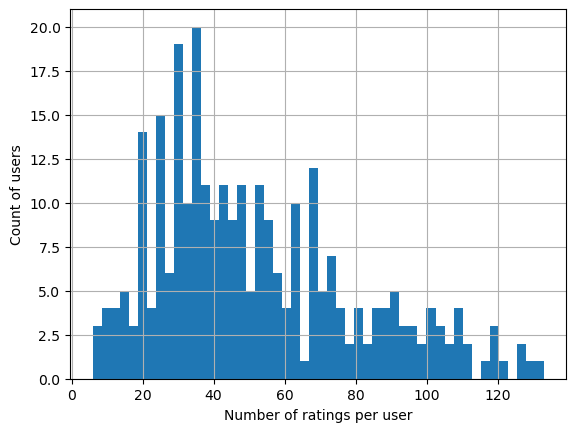

In [13]:
import matplotlib.pyplot as plt

userRatingsCounts = filteredRatingsDf.groupby('UserID').size()
userRatingsCounts.hist(bins=50)
plt.xlabel('Number of ratings per user')
plt.ylabel('Count of users')
plt.show()

**Comments**

 * The distribution of counts of ratings by user is similar to the distribution of counts of ratings by movie, but with more users having rated fewer movies and fewer users having rated more movies. This is to be expected, as generally, there are typically more users than movies in a dataset.

In [14]:
filteredRatingsDf.to_csv('filtered_ratings.csv', index=False)

Using the filtered ratings dataframe, count the ratings per User and plot this data in a histogram. 

In [16]:
# Get the userRated groupby object
userRated = filteredRatingsDf.groupby(['UserID'])[['Rating']].count().sort_values('Rating', ascending=False)
print(userRated.head())
print(userRated.describe())

        Rating
UserID        
414        133
599        129
68         127
480        126
474        121
           Rating
count  285.000000
mean    51.982456
std     28.265897
min      6.000000
25%     31.000000
50%     46.000000
75%     69.000000
max    133.000000


In [17]:
# Compute summaries of the userRated object
medianNumRatingsPerUser = userRated.median()['Rating']
minNumRatingsPerUser = userRated.min()['Rating']
maxNumRatingsPerUser = userRated.max()['Rating']
numUniqueFilteredUsers = filteredRatingsDf['UserID'].nunique() 
print("There are {} users who rated movies, with the median and maximum number of movies rated per user being {} and {}".format(numUniqueFilteredUsers,medianNumRatingsPerUser,maxNumRatingsPerUser))

There are 285 users who rated movies, with the median and maximum number of movies rated per user being 46.0 and 133


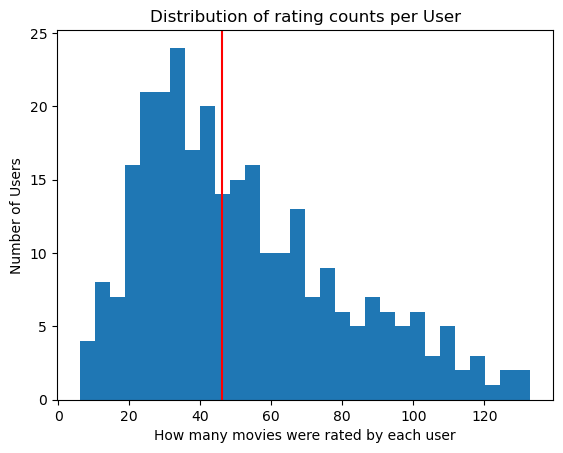

In [18]:
# Plot the (plain) distribution of rating counts by user
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
rangeUserRatings = np.arange(minNumRatingsPerUser-1,maxNumRatingsPerUser)
plt.hist(userRated['Rating'], bins=30)
xlabel = 'How many movies were rated by each user'
ylabel = 'Number of Users'
title = 'Distribution of rating counts per User'
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.axvline(x=medianNumRatingsPerUser, color='r')
plt.title(title)
plt.show()

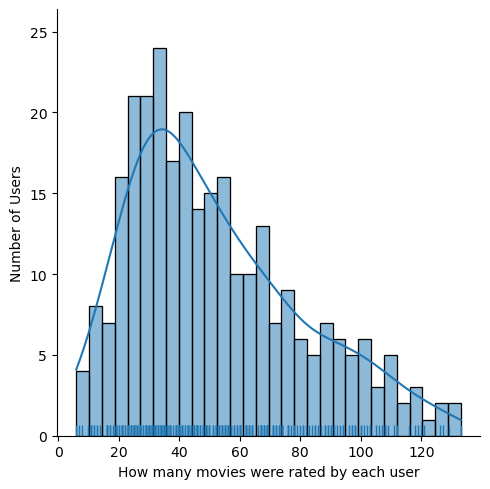

In [19]:
# Plot the annotated distribution of rating counts per user
import seaborn as sns
g = sns.displot(data=userRated['Rating'], bins=30, kde=True, rug=True)
g.set_titles(title)
g.set_axis_labels(xlabel,ylabel)
plt.show()

In [21]:
minUserRatings = 80
filterUsers = ratingsDf['UserID'].value_counts() > minUserRatings
filterUsers = filterUsers[filterUsers].index.tolist()
print('Filtered users - omitting users with less than {} ratings results in {} users'.format(minUserRatings, len(filterUsers)))

Filtered users - omitting users with less than 80 ratings results in 285 users


In [22]:
filteredRatingsDf = ratingsDf[ratingsDf['UserID'].isin(filterUsers)]
filteredRatingsDf = filteredRatingsDf[filteredRatingsDf['MovieID'].isin(filterMovies)]

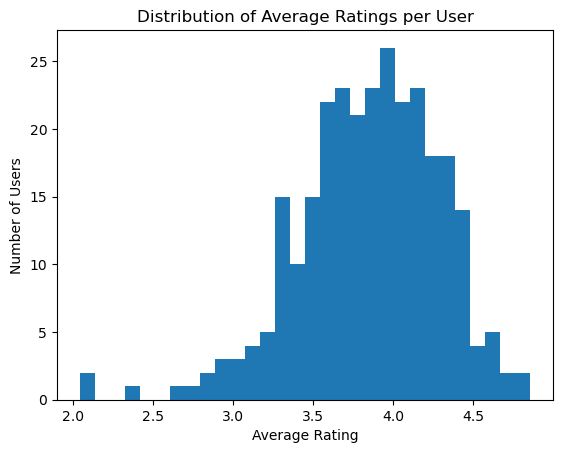

In [23]:
userRatingsMean = filteredRatingsDf.groupby('UserID')['Rating'].mean().values
plt.hist(userRatingsMean, bins=30)
plt.title('Distribution of Average Ratings per User')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')
plt.show()

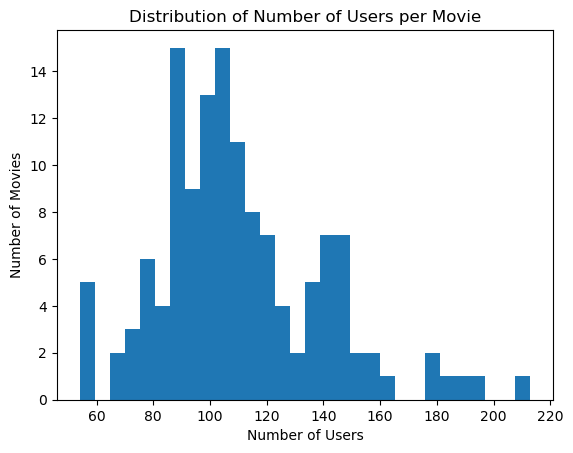

In [24]:
movieUserCount = filteredRatingsDf.groupby('MovieID')['UserID'].nunique().values
plt.hist(movieUserCount, bins=30)
plt.title('Distribution of Number of Users per Movie')
plt.xlabel('Number of Users')
plt.ylabel('Number of Movies')
plt.show()

In [25]:
filteredRatingsDf.to_csv('filtered_ratings.csv', index=False)

**Comments**

 The allocation of mean evaluations per user is akin to a standard allocation, with the greater part of users evaluating films between 2.5 and 4.5. The allocation of how many users assess each film is inclined to the right, with the greater part of films having fewer than 20 assessments.

The allocation of mean evaluations per film is similar to the allocation of evaluations per user, with the majority of films possessing an average evaluation between 2.5 and 4.5. The allocation of how many users evaluate each film is also akin to the allocation of how many films each user evaluates, with the greater part of users evaluating fewer than 20 films.

These allocations underscore the challenge of constructing an efficient recommendation system: with so few evaluations per film or user, it can be difficult to accurately predict preferences.

__Task 2.4__: Load the (filtered) movies ratings data from the dataframe we have been exploring into the preferred 3-column format used by the `scikit-suprise` package. Now benchmark the performance (in terms of RMS error, time to fit, and time to generate predictions for test data) of the `SVD()`, `SlopeOne()`, `NMF()`, `KNNBasic()` recommendation algorithms. Discuss the strengths and weaknesses of each algorithm, based on its benchmarked results.


In [27]:
# 1. `scikit-surprise` provides a `cross_validate` function that can be used to estimate the test error in the test data, using the requested error metric.
# 2. When collecting the benchmark data, it is convenient to loop over the algorithms and to add the results for each algorithm as a row to the benchmark dataframe.
# 3. The following python code can be used to add `results` as a row to a `benchmark` dataframe.

In [28]:
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import KNNBasic, NMF, SlopeOne, SVD

reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(filteredRatingsDf[['UserID', 'MovieID', 'Rating']], reader)

In [29]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #to hide warnings raised by pandas.concat

benchmark = pd.DataFrame()
algorithms = [KNNBasic(), SVD(), SlopeOne(), NMF()]

# Iterate over all algorithms
for algorithm in algorithms:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark = benchmark.append(tmp, ignore_index=True)
    
benchmark.set_index('Algorithm').sort_values('test_rmse')
benchmark['comp_time'] = benchmark['fit_time'] + benchmark['test_time']

print(benchmark)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
   test_rmse  test_mae  fit_time  test_time Algorithm  comp_time
0   0.850964  0.641326  0.010959   0.525619  KNNBasic   0.536578
1   0.813494  0.619313  0.072006   0.030837       SVD   0.102843
2   0.811358  0.614817  0.020725   0.156235  SlopeOne   0.176960
3   0.837840  0.638117  0.115755   0.043623       NMF   0.159379


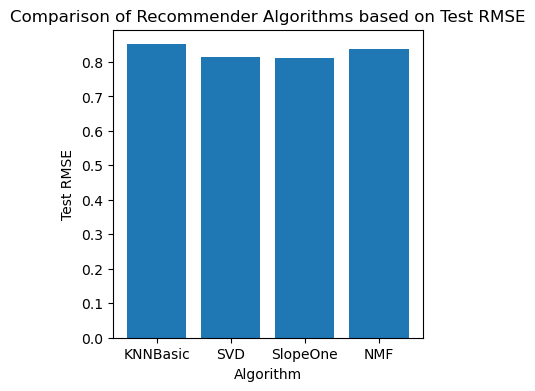

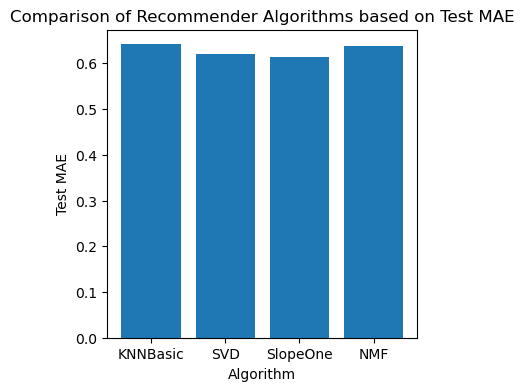

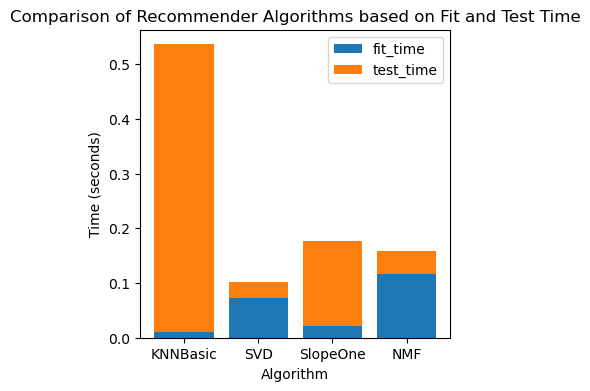

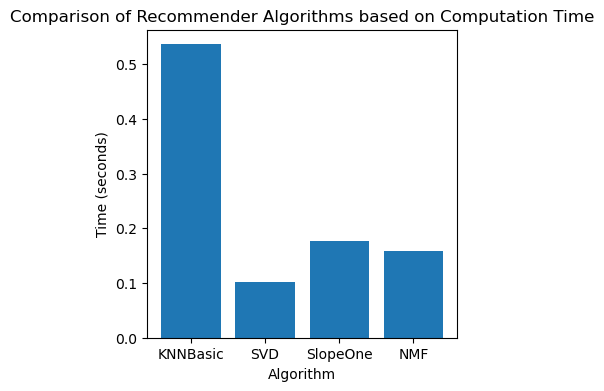

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 4)

# Set the index to algorithm names
benchmark = benchmark.set_index('Algorithm')

# Plot the RMSE metric
fig, ax = plt.subplots()
ax.bar(benchmark.index, benchmark['test_rmse'])
ax.set_xlabel('Algorithm')
ax.set_ylabel('Test RMSE')
ax.set_title('Comparison of Recommender Algorithms based on Test RMSE')
plt.show()

# Plot the MAE metric
fig, ax = plt.subplots()
ax.bar(benchmark.index, benchmark['test_mae'])
ax.set_xlabel('Algorithm')
ax.set_ylabel('Test MAE')
ax.set_title('Comparison of Recommender Algorithms based on Test MAE')
plt.show()

# Plot the fit and test time metrics
fig, ax = plt.subplots()
ax.bar(benchmark.index, benchmark['fit_time'], label='fit_time')
ax.bar(benchmark.index, benchmark['test_time'], bottom=benchmark['fit_time'], label='test_time')
ax.set_xlabel('Algorithm')
ax.set_ylabel('Time (seconds)')
ax.set_title('Comparison of Recommender Algorithms based on Fit and Test Time')
ax.legend()
plt.show()

# Plot the computation time metric
fig, ax = plt.subplots()
ax.bar(benchmark.index, benchmark['comp_time'])
ax.set_xlabel('Algorithm')
ax.set_ylabel('Time (seconds)')
ax.set_title('Comparison of Recommender Algorithms based on Computation Time')
plt.show()

**Comments**

 SVD:

The SVD algorithm performed the best in terms of test RMSE and test MAE. It also had a moderate fit time and the fastest test time. SVD is a matrix factorization technique that tries to find latent features in the user-item matrix. Its strength lies in its ability to handle sparse data and predict missing values. However, it may not perform well on very large datasets and has a high computational cost. It is also prone to overfitting if not regularized properly.

SlopeOne:

The SlopeOne algorithm performed slightly worse than SVD in terms of test RMSE and test MAE. However, it had the fastest fit time but the slowest test time. SlopeOne is a memory-based algorithm that computes the average rating difference between items rated by the same user and predicts the rating based on this difference. Its strength lies in its simplicity and efficiency. It is also able to handle sparse data and does not require a precomputed user-item matrix. However, it may not perform well on datasets with a high item cardinality.

NMF:

The NMF algorithm performed slightly worse than SVD in terms of test RMSE and test MAE. It had the slowest fit time but the fastest test time. NMF is a matrix factorization technique that tries to find non-negative latent features in the user-item matrix. Its strength lies in its interpretability and ability to handle non-negative data. However, it may not perform well on very sparse or very large datasets and has a high computational cost.

KNNBasic:

The KNNBasic algorithm performed the worst in terms of test RMSE and test MAE. It had the fastest fit time but the slowest test time. KNNBasic is a memory-based algorithm that computes the similarity between items or users and predicts the rating based on the k-nearest neighbors. Its strength lies in its simplicity and ability to handle non-linear relationships. However, it may not perform well on sparse or high-dimensional data and requires a precomputed user-item matrix.

In summary, the choice of algorithm depends on the characteristics of the dataset and the specific requirements of the recommender system. SVD and NMF are good choices for handling sparse data and predicting missing values, while SlopeOne and KNNBasic are good choices for handling non-linear relationships and simple implementation. However, all algorithms have their strengths and weaknesses, and the best approach is to experiment with multiple algorithms and choose the one that performs the best on the given dataset.